In [ ]:
!nvidia-smi

Fri Feb 12 19:01:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, datasets
import torch.optim as optim

import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

In [ ]:
print(torch.__version__)

1.7.0+cu101


# **Model**

In [ ]:
# Model
class Siamese_Net(nn.Module):
  def __init__(self):
    super(Siamese_Net,self).__init__()

    self.conv1=nn.Conv2d(1,64,10)
    self.conv2=nn.Conv2d(64,128,7)
    self.conv3=nn.Conv2d(128,128,4)
    self.conv4=nn.Conv2d(128,256,4)

    self.Linear1=nn.Linear(9216,4096)
    self.flatten=nn.Flatten()
    self.Linear2=nn.Linear(4096,1)

    self.relu=nn.ReLU()
    self.maxP=nn.MaxPool2d(2)
    self.sigm=nn.Sigmoid()

    # self.initialize_weights()

  def twin(self,x):

    out=self.conv1(x)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv2(out)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv3(out)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv4(out)
    out=self.relu(out)

    # test=out.view(out.size()[0], -1)
    out=self.flatten(out)
    # print(test==out) ##result -> true

    out=self.Linear1(out)
    out=self.sigm(out)

    return out

  def forward(self,x1,x2):

    x1_out=self.twin(x1)
    x2_out=self.twin(x2)

    # score= linear(distance between vectors)
    score=self.Linear2(torch.abs(x1_out-x2_out))

    # print(score)
    
    return score

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight,0,1e-2)
        nn.init.normal_(m.bias, 0.5, 1e-2)
      if isinstance(m,nn.Linear):
        nn.init.normal_(m.weight,0,2e-2)
        nn.init.normal_(m.bias, 0.5, 1e-2)



In [ ]:
#testing
net=Siamese_Net()
# print(net)
dummyx1=torch.randn(64,1,105,105)
dummyx2=torch.randn(64,1,105,105)
o=net(dummyx1,dummyx2)
print(o.shape)

torch.Size([64, 1])


# **Omniglot Dataset**

In [ ]:
# download the dataset
omni_train=datasets.Omniglot(root='/content', 
                       background= True,  
                       download = True
                       )

omni_test=datasets.Omniglot(root='/content', 
                       background= False,  
                       download = True
                       )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Omniglot dataset- didnt rename cause would have had to rename it everywhere
class Face_Dataset(Dataset):
  def __init__(self,root_dir, job='train',ways=10,transform=None):
    super(Face_Dataset,self).__init__()
    self.root_dir=root_dir
    self.job=job
    self.all_classes=os.listdir(root_dir)
    self.num_classes=len(self.all_classes)
    self.face_list, self.number_of_faces=self.get_char_list()
    self.ways=ways
    self.transform=transform
    print(self.all_classes)

  def __len__(self):
    return self.number_of_faces

  def __getitem__(self,idx):
    if self.job=='train':
      is_Same=1
      # Same person if even
      if idx%2==0:
        path_img_1,path_img_2,_=self.get_same()
      # different people 
      else:
        is_Same=0
        path_img_1,path_img_2=self.get_different()

      img1=Image.open(path_img_1).convert('L')
      img2=Image.open(path_img_2).convert('L')
      
      if self.transform:
        img1=self.transform(img1)
        img2=self.transform(img2)

      return img1,img2,torch.tensor([is_Same], dtype=torch.float32)

    else:
      img_list=[]
      ways=self.ways

      # grab two images from the same class
      path_img_1,path_img_2,id_to_avoid=self.get_same()
      img_list+=[path_img_1,path_img_2]

      ways=(ways-2)//2

      # and two from different classes
      for i in range(ways):
        img_list+=self.get_different(id_to_avoid)

      for i in range(len(img_list)):
        img=Image.open(img_list[i]).convert('L')
        if self.transform:
          img=self.transform(img)
        img_list[i]=img

      img_list_tensor=torch.stack(img_list)
      return img_list_tensor

  def get_char_list(self) -> (dict, int):
      a_list,n_letters={},0
      for idx, alpha in enumerate(self.all_classes):
        a_list[idx]=[]
        for char in os.listdir(os.path.join(self.root_dir,alpha)):
          l_list=[]
          for letter in os.listdir(os.path.join(self.root_dir,alpha,char)):
            l_list.append(os.path.join(self.root_dir,alpha,char,letter))
            n_letters+=1
          a_list[idx].append(l_list)
      return a_list,n_letters

  def get_same(self) -> (str, str, int):
    alpha_id=random.randint(0,self.num_classes-1)
    char_id=random.randint(0,len(self.face_list[alpha_id])-1)
    path_img_1=random.choice(self.face_list[alpha_id][char_id])
    path_img_2=random.choice(self.face_list[alpha_id][char_id])
    return path_img_1,path_img_2,char_id

  def get_different(self, avoid=None)-> (str, str):

    alpha_id_1=random.randint(0,self.num_classes-1)
    char_id_1=random.randint(0,len(self.face_list[alpha_id_1])-1)
    while char_id_1==avoid:
      char_id_1=random.randint(0,len(self.face_list[alpha_id_1])-1)

    alpha_id_2=random.randint(0,self.num_classes-1)
    char_id_2=random.randint(0,len(self.face_list[alpha_id_2])-1)
    while char_id_2==char_id_1 or char_id_2==avoid:
      char_id_2=random.randint(0,len(self.face_list[alpha_id_2])-1)

    path_img_1=random.choice(self.face_list[alpha_id_1][char_id_1])
    path_img_2=random.choice(self.face_list[alpha_id_2][char_id_2])
    return path_img_1,path_img_2
      

In [ ]:
a=torch.randn((64,3,122,450),dtype=torch.float32)
b=torch.randn((64,3,122,450),dtype=torch.float32)
c=torch.randn((64,3,122,450),dtype=torch.float32)
l=[a,b,c]
lt=torch.stack(l)
print(lt.shape)
print(lt[0,:].shape)

torch.Size([3, 64, 3, 122, 450])
torch.Size([64, 3, 122, 450])


In [ ]:
# omniglot root
train_root='/content/omniglot-py/images_background'
val_root='/content/omniglot-py/images_evaluation'
batch_size=16
ways=10

In [ ]:
# Omniglot Calculating the mean and std of the data

def find_mean_std(to_be_norm_dataset, batch_s=1):
  to_norm_loader=DataLoader(dataset=to_be_norm_dataset, batch_size=batch_s)
  print('Total number of samples: ', len(to_be_norm_dataset))

  # #run for 1 batch 
  # data_iter=iter(to_norm_loader)
  # img,_,__=data_iter.next()
  # print(img.shape)
  
  channels_sum, channels_squared_sum, num_batches=0, 0, 0
  for img,_,__ in to_norm_loader:
    # print(img.shape)#[batch,C,H,W]
    channels_sum+=torch.mean(img,dim=[0,2,3])
    channels_squared_sum+=torch.mean(img**2,dim=[0,2,3])
    num_batches+=1
  
  mean=channels_sum/num_batches
  std=(channels_squared_sum/num_batches- mean**2)**0.5
  return mean, std

to_be_norm_dataset=Face_Dataset(train_root, transform=transforms.Compose([
                                                             transforms.Resize((105,105)),
                                                             transforms.ToTensor()
                                           ]))

mean, std= find_mean_std(to_be_norm_dataset, batch_s=batch_size)

print(f'mean: {mean.item()}    std: {std.item()}')

['N_Ko', 'Greek', 'Japanese_(katakana)', 'Anglo-Saxon_Futhorc', 'Futurama', 'Cyrillic', 'Burmese_(Myanmar)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Hebrew', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'Early_Aramaic', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Alphabet_of_the_Magi', 'Bengali', 'Gujarati', 'Balinese', 'Asomtavruli_(Georgian)', 'Braille', 'Syriac_(Estrangelo)', 'Tagalog', 'Sanskrit', 'Tifinagh', 'Latin', 'Japanese_(hiragana)', 'Korean', 'Armenian']
Total number of samples:  19280
mean: 0.923902690410614    std: 0.2651536762714386


In [ ]:
# prepare datasets(OMNIGLOT)

transform=transforms.Compose([
                              transforms.Resize((105,105)),
                              transforms.RandomAffine(30,shear=0.2),
                              transforms.ToTensor(),
                              transforms.Normalize([mean.item()],[std.item()]),
])
# dataset=Face_Dataset(root,transform=transform)
dataset_train=Face_Dataset(train_root, transform=transform)
dataset_val=Face_Dataset(val_root,job='val', ways=ways, transform=transforms.Compose([transforms.Resize((105,105)),
                                                            transforms.ToTensor()])
)

dataloader_train=DataLoader(dataset=dataset_train, batch_size=batch_size)
dataloader_val=DataLoader(dataset=dataset_val, batch_size=batch_size)


['N_Ko', 'Greek', 'Japanese_(katakana)', 'Anglo-Saxon_Futhorc', 'Futurama', 'Cyrillic', 'Burmese_(Myanmar)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Hebrew', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'Early_Aramaic', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Alphabet_of_the_Magi', 'Bengali', 'Gujarati', 'Balinese', 'Asomtavruli_(Georgian)', 'Braille', 'Syriac_(Estrangelo)', 'Tagalog', 'Sanskrit', 'Tifinagh', 'Latin', 'Japanese_(hiragana)', 'Korean', 'Armenian']
['Kannada', 'Oriya', 'Gurmukhi', 'Atemayar_Qelisayer', 'Malayalam', 'Atlantean', 'Syriac_(Serto)', 'Ge_ez', 'Manipuri', 'ULOG', 'Glagolitic', 'Angelic', 'Aurek-Besh', 'Tibetan', 'Mongolian', 'Tengwar', 'Avesta', 'Old_Church_Slavonic_(Cyrillic)', 'Keble', 'Sylheti']


# Check if the datasets are working

0.0
torch.Size([1, 105, 105]) 
 torch.Size([1, 105, 105])
(105, 105) 
 (105, 105)


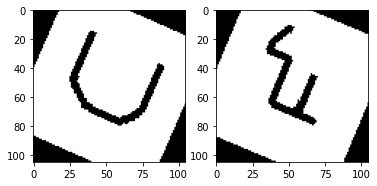

In [ ]:
# Testing train Dataset
img1,img2,are_Same=dataset_train[1]

print(are_Same.item())
print(img1.shape,'\n',img2.shape)

# convert to PIL and multiply with std and add mean to un-normalize the images for viewing purposes only
show_img1=transforms.ToPILImage()(img1.mul_(std).add_(mean))
show_img2=transforms.ToPILImage()(img2.mul_(std).add_(mean))

print(show_img1.size,'\n',show_img2.size)

plt.subplot(121)
plt.imshow(show_img1,cmap='gray')

plt.subplot(122)
plt.imshow(show_img2,cmap='gray')


torch.Size([10, 1, 105, 105]) torch.Size([1, 105, 105])


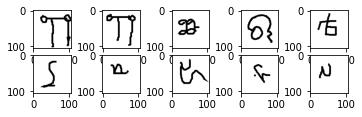

In [ ]:
# Testing validation Dataset
imgs=dataset_val[0]

print(imgs.shape, imgs[0,:].shape)

# data_iter=iter(dataloader_val)
# images=data_iter.next()
# print(images.shape) #torch.Size([16, 10, 1, 105, 105])

for i in range(ways):
  img=imgs[i,:]
  plt.subplot(5,5,(i+1))
  plt.imshow(transforms.ToPILImage()(img), cmap='gray')


# **Training**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=Siamese_Net().to(device)

loss_function=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=3e-4,weight_decay=6e-5)
# lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)
lr_scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, verbose=True)

epochs=500

Adjusting learning rate of group 0 to 3.0000e-04.


In [ ]:
# Train Network

t_loss,accuracy=[],[]
val_every=1
save_every=50

for epoch in range(epochs+1):
  t_loss_batch=[]
  
  # ----------------------training---------------------------------------------
  model.train()
  for batch_idx, (img1, img2, isSame) in enumerate(dataloader_train):
    # Get data to cuda if possible
    img1, img2, isSame= img1.to(device),img2.to(device),isSame.to(device)

    # forward
    scores = model(img1, img2)
    loss = loss_function(scores, isSame)
    
    # backward
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()

    t_loss_batch.append(loss.item())
  
  mean_loss=sum(t_loss_batch)/len(t_loss_batch)
  t_loss.append(mean_loss)
  # ------------------------lr scheduler---------------------------------------------
  
  # for ExponentialLR 
  # lr_scheduler.step()
  
  # forReduceLROnPlateau
  # lr_scheduler.step(mean_loss)
  
  # -----------------------------Validation----------------------------------
  if epoch%val_every==0:
    model.eval()
    with torch.no_grad():
      batch_accuracy=[]
      for batch_idx,images in enumerate(dataloader_val):
        score_l,correct=[],0
        images=images.to(device)
        img1=images[:,0,:]

        for i in range(1,ways):
          score=torch.sigmoid(model(img1,images[:,i,:]))
          score_l.append(score)

        scores=torch.stack(score_l)

        results=torch.argmax(scores,0)

        for i in range(results.shape[0]):
          if results[i,:].item()==0:
            correct+=1

        total=images.shape[0]
        batch_accuracy.append(correct/total)

      # finding the accuracy of that epoch
      accuracy.append(sum(batch_accuracy)/len(batch_accuracy))
    print(f'Epoch No.:{epoch} training loss:{t_loss[-1]}  validation accuracy:{accuracy[-1]*100}%')
  
  if epoch%save_every==0:
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': t_loss[-1],
            }, f'/content/drive/MyDrive/dataset/ckpts_newest/checkp{epoch}.pt')
    

Epoch No.:0 training loss:0.5438833923013379  validation accuracy:12.644114077669903%
Epoch No.:1 training loss:0.44210063513383824  validation accuracy:13.129550970873785%
Epoch No.:2 training loss:0.34877433553028897  validation accuracy:15.4100930420712%
Epoch No.:3 training loss:0.2839657190986194  validation accuracy:9.301678802588995%
Epoch No.:4 training loss:0.23512573462767966  validation accuracy:9.466019417475728%
Epoch No.:5 training loss:0.20199604559210574  validation accuracy:14.972694174757281%
Epoch No.:6 training loss:0.1917566453520193  validation accuracy:11.736448220064725%
Epoch No.:7 training loss:0.17663329681420228  validation accuracy:21.2353357605178%
Epoch No.:8 training loss:0.16417881500872464  validation accuracy:17.880258899676377%
Epoch No.:9 training loss:0.15639627440465437  validation accuracy:9.392698220064725%
Epoch No.:10 training loss:0.15576457058338455  validation accuracy:12.765473300970873%
Epoch No.:11 training loss:0.14365739802833785  vali

Mean Loss: 0.054


Text(0, 0.5, 'Loss')

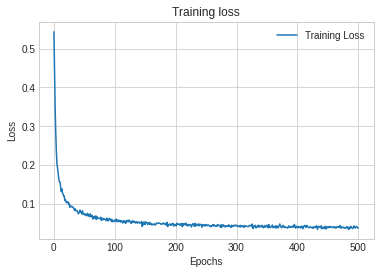

In [ ]:
print(f'Mean Loss: {sum(t_loss)/len(t_loss):.3f}')
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax = plt.axes()
ax.plot(t_loss,label='Training Loss')
# ax.plot(v_loss,label='Validation Loss')
ax.legend()
ax.set_title('Training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

Mean Accuracy: 14.416%
0.35821197411003236


Text(0, 0.5, 'Accuracy')

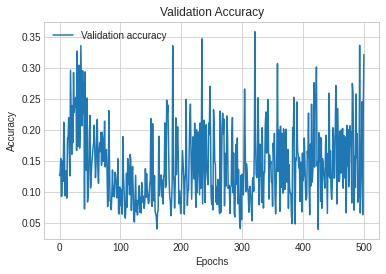

In [ ]:
print(f'Mean Accuracy: {sum(accuracy)/len(accuracy)*100:.3f}%')
print(max(accuracy))
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
ax.plot(accuracy,label='Validation accuracy')
# ax.plot(v_loss,label='Validation Loss')
ax.legend()
ax.set_title('Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

In [ ]:
# training accuracy for Omniglot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=Siamese_Net().to(device)
checkpoint = torch.load('/content/drive/MyDrive/dataset/ckpts_newest/checkp500.pt')
model.load_state_dict(checkpoint['model_state_dict'])

ways=4

dataset_train_acc=Face_Dataset(train_root,job='val', ways=ways,transform=transforms.Compose([transforms.Resize((105,105)),
                                                            transforms.ToTensor()])
)

dataloader_train_acc=DataLoader(dataset=dataset_train_acc, batch_size=batch_size)

# finding accuracy
model.eval()
with torch.no_grad():
  batch_accuracy=[]
  for batch_idx,images in enumerate(dataloader_train_acc):
    score_l,correct=[],0
    images=images.to(device)
    img1=images[:,0,:]

    for i in range(1,ways):
      score=torch.sigmoid(model(img1,images[:,i,:]))
      score_l.append(score)

    scores=torch.stack(score_l)

    results=torch.argmax(scores,0)

    for i in range(results.shape[0]):
      if results[i,:].item()==0:
        correct+=1

    total=images.shape[0]
    batch_accuracy.append(correct/total)
  print(f'Training accuracy: {sum(batch_accuracy)/len(batch_accuracy)*100:.3f}%')

['N_Ko', 'Greek', 'Japanese_(katakana)', 'Anglo-Saxon_Futhorc', 'Futurama', 'Cyrillic', 'Burmese_(Myanmar)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Hebrew', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'Early_Aramaic', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Alphabet_of_the_Magi', 'Bengali', 'Gujarati', 'Balinese', 'Asomtavruli_(Georgian)', 'Braille', 'Syriac_(Estrangelo)', 'Tagalog', 'Sanskrit', 'Tifinagh', 'Latin', 'Japanese_(hiragana)', 'Korean', 'Armenian']
Training accuracy: 58.781%
